In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.filters import threshold_otsu
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [54]:
def load_images(before_path, after_path):
    """加载并预处理图像"""
    img_before = cv2.imread(before_path)
    img_after = cv2.imread(after_path)
    return img_before, img_after

def register_images(img_before, img_after):
    """刚性配准核心算法"""
    # 转换为灰度图
    gray_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
    gray_after = cv2.cvtColor(img_after, cv2.COLOR_BGR2GRAY)

    # 使用AKAZE特征（对光照变化更鲁棒）
    detector = cv2.AKAZE_create()
    kp1, des1 = detector.detectAndCompute(gray_before, None)
    kp2, des2 = detector.detectAndCompute(gray_after, None)

    # 特征匹配
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.knnMatch(des1, des2, k=2)

    # Lowe's比率测试
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    # 计算变换矩阵
    if len(good) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
        
        # 使用相似变换（包含旋转、平移和缩放）
        M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
        
        # 对齐图像
        h, w = img_after.shape[:2]
        aligned = cv2.warpAffine(img_before, M, (w, h))
        return aligned, M
    return None, None

def generate_heatmap(img_before, img_after):
    """生成磨损热力图"""
    # 图像配准
    aligned, _ = register_images(img_before, img_after)
    
    if aligned is None:
        raise ValueError("图像配准失败，请检查特征匹配结果")

    # 转换为灰度图计算差异
    gray_before = cv2.cvtColor(aligned, cv2.COLOR_BGR2GRAY)
    gray_after = cv2.cvtColor(img_after, cv2.COLOR_BGR2GRAY)

    # 计算结构相似性差异
    diff = cv2.absdiff(gray_before, gray_after)
    
    # 高斯模糊降噪
    diff = cv2.GaussianBlur(diff, (5,5), 0)
    
    # 归一化到0-255范围
    norm_diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)
    
    # 生成热力图
    heatmap = cv2.applyColorMap(norm_diff.astype(np.uint8), cv2.COLORMAP_JET)
    
    return heatmap, norm_diff

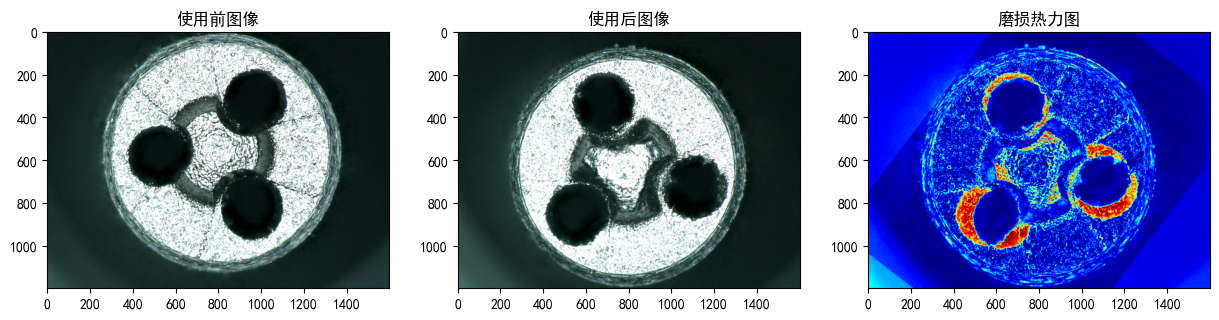

In [55]:
before_path = "../datas/imgs/items/new.jpg"
after_path = "../datas/imgs/items/old.jpg"
# fixed_img = cv2.imread(before_path)  # 使用前图像
# moving_img = cv2.imread(after_path)  # 使用后图像

# 加载图像（替换为实际路径）
img_before, img_after = load_images(before_path, after_path)

# 生成热力图
heatmap, diff_map = generate_heatmap(img_before, img_after)

# 可视化结果
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB))
plt.title("使用前图像")

plt.subplot(132)
plt.imshow(cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB))
plt.title("使用后图像")

plt.subplot(133)
plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
plt.title("磨损热力图")

plt.show()